<a href="https://colab.research.google.com/github/Tejas-Chaudhari-007/MM-749-Statistics-and-Probability/blob/main/Distributional_Analysis_(failed_attempts).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt
import pylab
%matplotlib inline


In [ ]:
# Load data and select first column
df = pd.read_csv('/content/Metallic_Glass_Forming_with_features.csv')
y = df['Trg']

# Create an index array (x) for data
x = np.arange(len(y))
size = len(y)

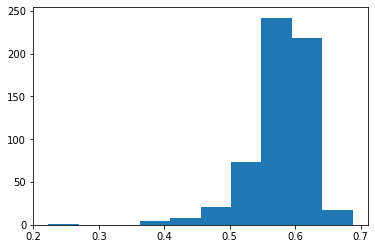

In [ ]:
plt.hist(y)
plt.show()

In [ ]:
y_df = pd.DataFrame(y, columns=['Trg'])
y_df.describe()

,Trg
count,585.000000
mean,0.577388
std,0.048344
min,0.223000
25%,0.557000
50%,0.584000
75%,0.609000
max,0.688000


In [ ]:
sc=StandardScaler() 
y = np.array(y)  # this is required since y is a series and next command does not work on it
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

In [ ]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
8  weibull_min     80.503237  0.04185
0         beta    148.649334  0.00481
4         norm    345.070140  0.00004
3      lognorm    348.315954  0.00004
2        gamma    632.670487  0.00000
9  weibull_max   4708.528991  0.00000
6       triang  11853.342689  0.00000
1        expon  20219.972589  0.00000
7      uniform  26276.986680  0.00000
5     pearson3  60819.567405  0.00000


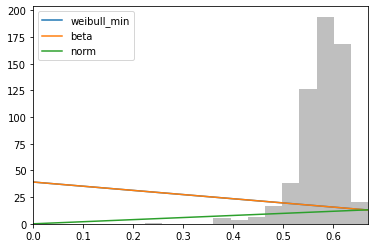


Distribution parameters:
------------------------

Distribution: weibull_min
Parameters: (40.316691377128166, -0.9354045324441804, 1.5332057333386697)

Distribution: beta
Parameters: (424137552.1784962, 8.527937908531092, -6745684.457285518, 6745685.170085143)

Distribution: norm
Parameters: (0.5773880341880342, 0.04830280054593136)


In [ ]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 14
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

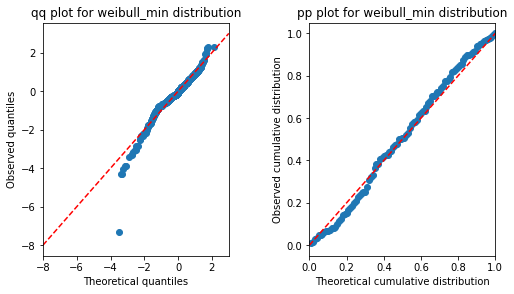

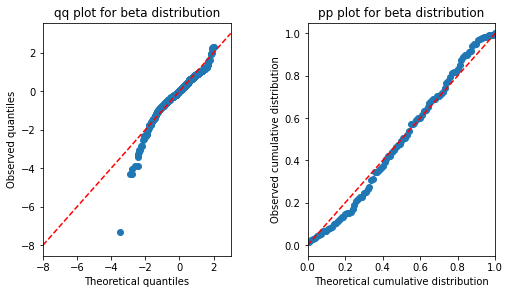

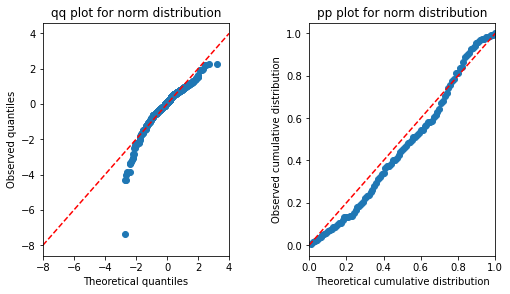

In [ ]:
## qq and pp plots
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(8,5)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # pp plot
    ax2 = fig.add_subplot(122)
    
    # Calculate cumulative distributions
    bins = np.percentile(norm,range(0,101))
    data_counts, bins = np.histogram(data,bins)
    norm_counts, bins = np.histogram(norm,bins)
    cum_data = np.cumsum(data_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_data = cum_data / max(cum_data)
    cum_norm = cum_norm / max(cum_norm)
    
    # plot
    ax2.plot(cum_norm,cum_data,"o")
    min_value = np.floor(min(min(cum_norm),min(cum_data)))
    max_value = np.ceil(max(max(cum_norm),max(cum_data)))
    ax2.plot([min_value,max_value],[min_value,max_value],'r--')
    ax2.set_xlim(min_value,max_value)
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    title = 'pp plot for ' + distribution +' distribution'
    ax2.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()

Remove outliers from Trg for better parametric probability distribution estimation:
Source: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [ ]:
# IQR method is used to remove the outliers as the data is not assumed to be Gaussian-like
data = df['Trg']
# Calculate IQR
q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
IQR = q75 - q25

# Calculate outlier cut-off
k_factor = 1.5
cut_off = k_factor * IQR 
lower_cut_off, upper_cut_off = q25 - cut_off, q75 + cut_off

# Identiy outliers
outliers = [x for x in data if x < lower_cut_off or x > upper_cut_off]
print(f'Number of outliers: {len(outliers)}')

# Remove outliers
data_without_outliers = [x for x in data if x >= lower_cut_off or x <= upper_cut_off]

Number of outliers: 25


Trying <scipy.stats._continuous_distns.alpha_gen object at 0x7f6c02441c10>
Trying <scipy.stats._continuous_distns.anglit_gen object at 0x7f6c02441d50>
Trying <scipy.stats._continuous_distns.arcsine_gen object at 0x7f6c024483d0>
Trying <scipy.stats._continuous_distns.beta_gen object at 0x7f6c02448290>
Trying <scipy.stats._continuous_distns.betaprime_gen object at 0x7f6c166412d0>
Trying <scipy.stats._continuous_distns.bradford_gen object at 0x7f6c02448950>
Trying <scipy.stats._continuous_distns.burr_gen object at 0x7f6c02448c10>
Trying <scipy.stats._continuous_distns.cauchy_gen object at 0x7f6c02454590>
Trying <scipy.stats._continuous_distns.chi_gen object at 0x7f6c024547d0>
Trying <scipy.stats._continuous_distns.chi2_gen object at 0x7f6c02454690>
Trying <scipy.stats._continuous_distns.cosine_gen object at 0x7f6c02454c50>
Trying <scipy.stats._continuous_distns.dgamma_gen object at 0x7f6c02454f50>
Trying <scipy.stats._continuous_distns.dweibull_gen object at 0x7f6c01f1b290>
Trying <scipy.

Text(0, 0.5, 'Frequency')

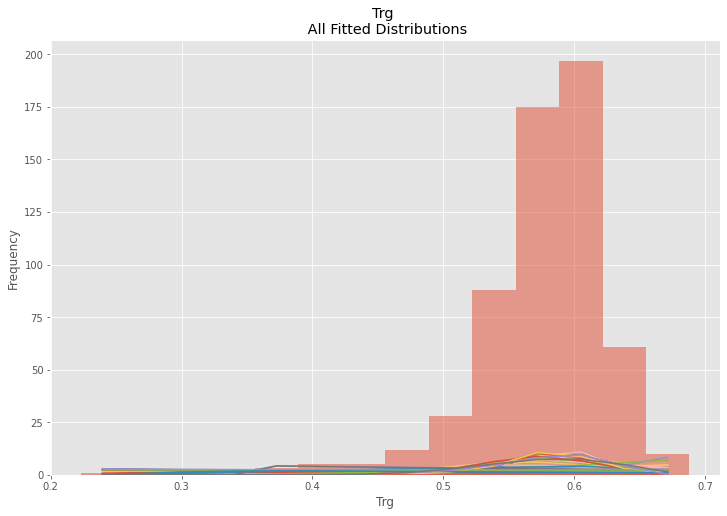

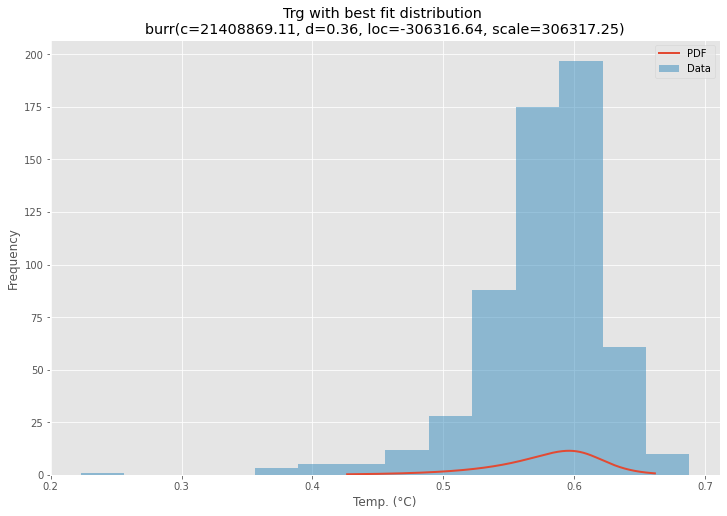

In [ ]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt



matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        print(f'Trying {distribution}')

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Input the data
data = pd.Series(data_without_outliers)


# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=14, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 14, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trg \n All Fitted Distributions')
ax.set_xlabel(u'Trg')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=14, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Trg with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

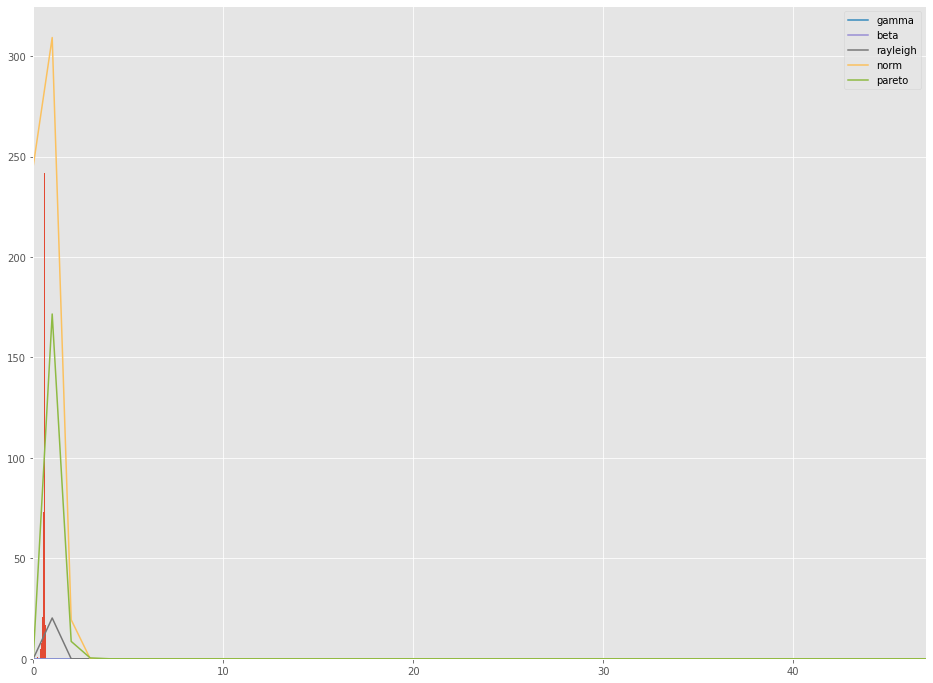

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
size = len(data_without_outliers)
x = np.arange(size)
y = data_without_outliers
h = plt.hist(y)

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=loc) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

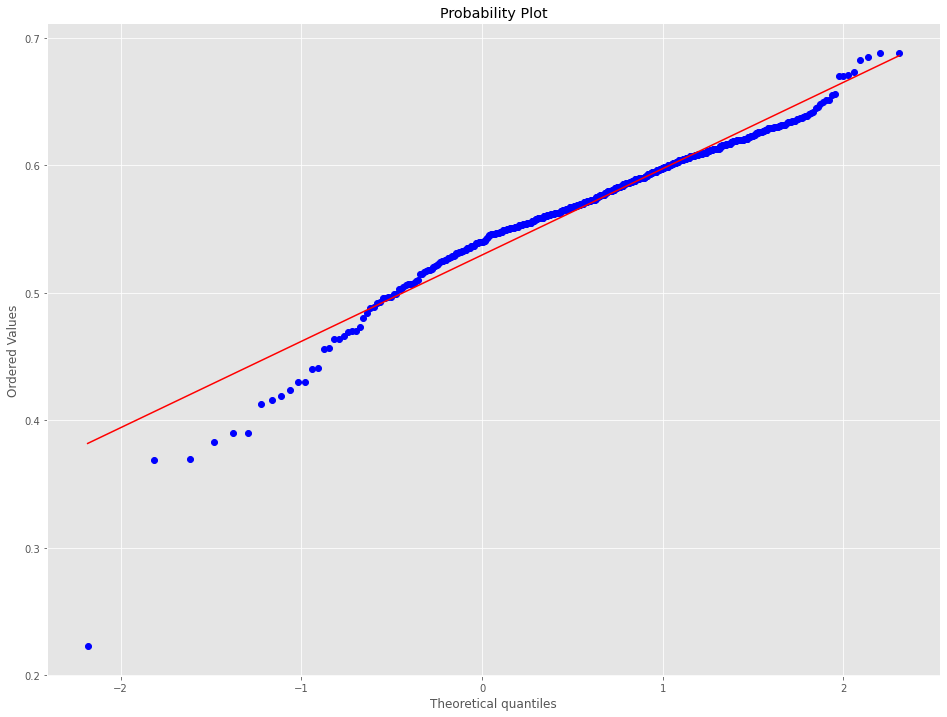

In [ ]:
data = df['Trg']
st.probplot(data, dist=st.loggamma, sparams=(2.5,), plot=pylab)
pylab.show()